In [1]:
# import libraries 
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import matplotlib.patches as mpatches
import seaborn as sns
import pickle
from scipy.cluster import hierarchy
import math
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import Birch
from sklearn.metrics import silhouette_score

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.cluster import AgglomerativeClustering

In [2]:
my_colors = ['#88292F', '#697268', '#12355B', '#D7816A', '#64a0e0', '#c33b43', 
               '#9DBF9E', '#343934', '#e8da6f','#280003','#cd5a61', '#913d27', 
               '#F46036', '#248232',  '#bea602', '#0a6682', '#646536', '#624763', '#2F1847', 
               '#FF7B9C', '#66A182', '#94849B', '#ACD8AA', '#F48498', '#B30089']
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', my_colors)

In [3]:
# import clean data set

df_solar_satellite = pd.read_csv('../../../1_data_analysis_and_preproc/intermediate/solar/solar_satellite_merged_raw.csv')

In [4]:
df_solar_satellite.head()

,asset_id,read_at,ac_power,ac_voltage,ac_current,dc_power,dc_voltage,dc_current,farm,global_tilted_irradiance,global_horizontal_irradiance,temperature,cloud_cover
0,11,2022-01-01 07:40:00,0.0,4.0,0.000,0.0000,2.73333,0.000,1,0.0,0.0,12.2,21.9
1,12,2022-01-01 07:40:00,0.0,3.0,0.000,0.0000,1.90000,0.000,1,0.0,0.0,12.2,21.9
2,13,2022-01-01 07:40:00,0.0,2.0,0.000,0.0000,2.10000,0.000,1,0.0,0.0,12.2,21.9
3,14,2022-01-01 07:40:00,13.0,232.0,0.113,14.1887,346.06700,0.041,1,0.0,0.0,12.2,21.9
4,15,2022-01-01 07:40:00,0.0,232.0,0.018,0.8127,270.90000,0.003,1,0.0,0.0,12.2,21.9


In [5]:
df_solar_satellite = df_solar_satellite[['asset_id', 'dc_power', 'dc_current', 'dc_voltage', 'temperature', 'cloud_cover']]

In [6]:
asset = df_solar_satellite['asset_id'].unique()[0]

length = len(df_solar_satellite[df_solar_satellite['asset_id'] == asset])

int(0.01 * length)  # Adjust the percentage as needed

521

In [7]:
np.random.seed(10)

asset = df_solar_satellite['asset_id'].unique()[0]

length = len(df_solar_satellite[df_solar_satellite['asset_id'] == asset])

subset_size = int(0.01 * length)  # Adjust the percentage as needed

# Group the DataFrame by the asset identifier column(s)
grouped = df_solar_satellite.groupby('asset_id')

# Initialize an empty list to store the sampled data
subset_data = []

# Iterate over each group, sample subset_size rows from each group, and append to subset_data
for _, group_df in grouped:
    sampled_group = group_df.sample(n=subset_size, replace=False)
    subset_data.append(sampled_group)

# Concatenate the sampled data from all groups into a single DataFrame
df_subset = pd.concat(subset_data)

In [8]:
len(df_subset)

40117

In [9]:
df_subset = df_subset.reset_index(drop=True)

In [10]:
X = df_subset.loc[:, 'dc_power':]
X = X.reset_index(drop=True)
X.head()

,dc_power,dc_current,dc_voltage,temperature,cloud_cover
0,1.46373,0.008,182.967,19.0,19.0
1,726.21900,2.386,304.367,20.4,0.0
2,861.01400,2.711,317.600,17.0,29.0
3,161.37300,0.560,288.167,16.0,72.0
4,5536.75000,18.223,303.833,12.0,2.0


In [11]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled)

# Perform PCA
n_components = 2
pca = PCA(n_components=n_components)
pca_result = pca.fit_transform(X_scaled)

# Create DataFrame with PCA results
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])

pca_df.head()

,PC1,PC2
0,1.073620,-2.073383
1,0.203757,-1.467581
2,1.005381,-1.059952
3,2.111048,-0.849120
4,-0.148070,-1.640123


trying to use PCA to explain 0.9 is not feasable as it only produces a df with 5 columns with 100% of explained variance. So, we'll try to use X_scaled.

In [34]:
# pca.explained_variance_ratio_

array([0.36115172, 0.22155765, 0.15592148])

In [35]:
# loadings = pca.components_

# absolute_loadings = np.abs(loadings)

# cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

# print(f'The cumulative explained variance ratio for {n_components} PCs is {cumulative_variance_ratio[-1]*100:.2f}% \n')

The cumulative explained variance ratio for 3 PCs is 73.86% 



In [17]:
# pd.DataFrame(absolute_loadings, columns=['dc_power', 'dc_voltage', 'dc_current', 'temperature', 'cloud_cover'])

,dc_power,dc_voltage,dc_current,temperature,cloud_cover
0,0.387795,0.543636,0.191561,0.513204,0.503986
1,0.517501,0.290045,0.760321,0.162966,0.208375
2,0.672821,0.368327,0.562200,0.165085,0.261391
3,0.196483,0.102215,0.206826,0.686307,0.661175
4,0.300857,0.688637,0.162387,0.460211,0.443960


In [12]:
df_scaled = X_scaled.copy()

In [13]:
pca_df.to_csv('pca_df.csv', index=False)
df_scaled.to_csv('df_scaled.csv', index=False)
df_subset.to_csv('df_subset.csv', index = False)

In [41]:
# Plot dendrogram
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)
    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

# Hierarchical clustering

## Aglomerative

## Single

In [43]:
# Fit Agglomerative Clustering model on the combined data
model_single = AgglomerativeClustering(linkage= 'single',distance_threshold=0.01, n_clusters=None)
model_single.fit(np.array(df_scaled))

AgglomerativeClustering(distance_threshold=0.01, linkage='single',
                        n_clusters=None)

In [44]:
with open('results/hierarchical/single_clustering.pickle', 'wb') as f:
    pickle.dump(model_single, f)

In [17]:
with open('results/hierarchical/single_clustering.pickle', 'rb') as f:
    model_single = pickle.load(f)

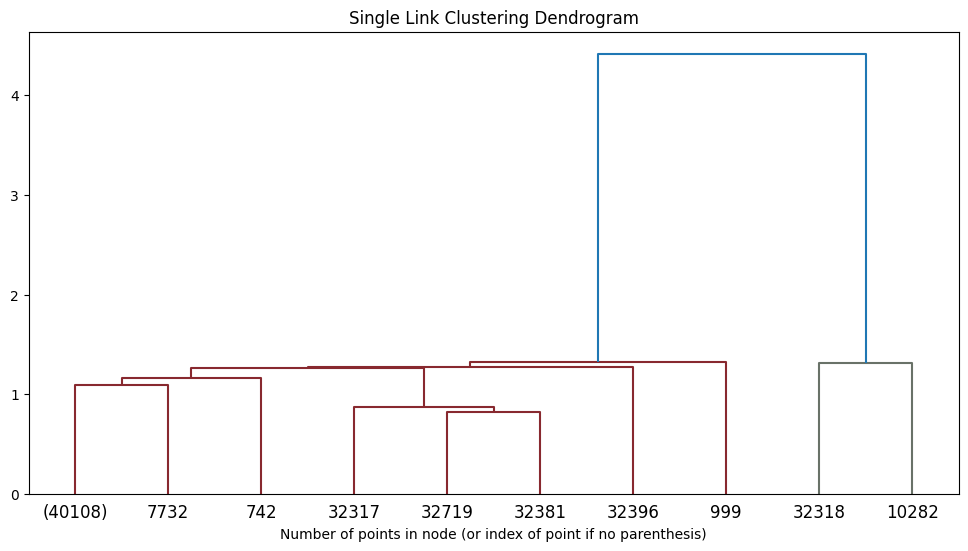

In [45]:
hierarchy.set_link_color_palette(my_colors)

plt.figure(figsize=(12, 6))
plt.title('Single Link Clustering Dendrogram')
# Plot the dendrogram
plot_dendrogram(model_single, truncate_mode='level', p = 5)
plt.xlabel("Number of points in node (or index of point if no parenthesis)")
plt.show()

In [46]:
# Cut dendrogram to obtain labels
num_clusters = 2  # Adjust as needed

# Convert the children_ attribute to a scipy hierarchical tree
linkage_matrix = np.column_stack([model_single.children_, model_single.distances_,
                                  np.ones_like(model_single.distances_)])
# Cut the tree to obtain labels
labels_cut = fcluster(linkage_matrix, num_clusters, criterion='maxclust')

len(np.unique(labels_cut))

2

In [47]:
pca_df = pca_df.loc[:,:'PC2']

In [63]:
# Assign the cluster labels to the original DataFrame
pca_df['cluster_label'] = labels_cut
pca_df['asset_id'] = df_subset['asset_id']

df_scaled['cluster_label'] = labels_cut
df_scaled['asset_id'] = df_subset['asset_id']

In [49]:
df_scaled.to_csv('results/hierarchical/csv_labels_cut_raw/single_link.csv', index = False)

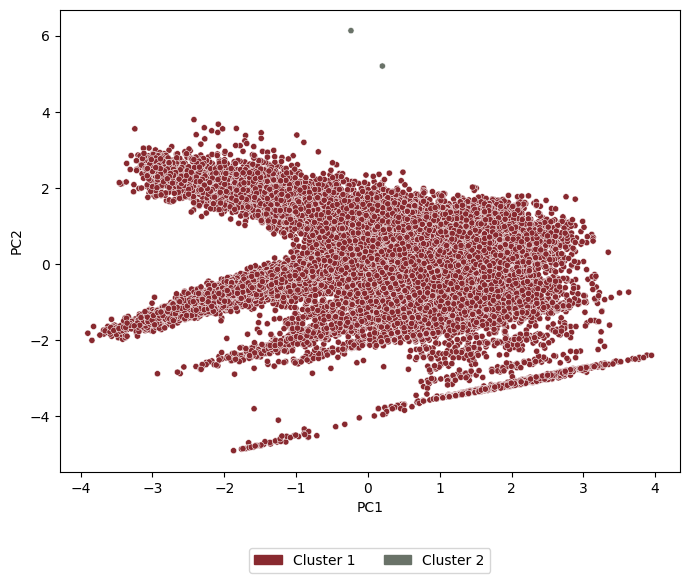

In [65]:
n_clusters = len(pca_df['cluster_label'].unique())
pallete = sns.color_palette(my_colors, n_clusters)

# Plot the representative points on a scatter plot using PCA results
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='cluster_label', palette=pallete, s=20)
# plt.title('Single Link')
plt.xlabel('PC1')
plt.ylabel('PC2')
legend_handles = [mpatches.Circle((0, 0), radius=1, color=color) for color in my_colors]
plt.legend(handles=legend_handles, labels=[f'Cluster {cluster_label}' for cluster_label in np.unique(labels_cut)],
           loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5)
plt.show()

In [66]:
most_frequent_clusters = pca_df.groupby('asset_id')['cluster_label'].agg(lambda x: np.bincount(x).argmax())

# Merge the most frequent cluster labels back to the original DataFrame
pca_df = pca_df.drop(columns='cluster_label')

pca_df = pd.merge(pca_df, most_frequent_clusters, on='asset_id', how='left')

pca_df.head()

,PC1,PC2,asset_id,cluster_label
0,1.073620,-2.073383,11,1
1,0.203757,-1.467581,11,1
2,1.005381,-1.059952,11,1
3,2.111048,-0.849120,11,1
4,-0.148070,-1.640123,11,1


In [67]:
len(most_frequent_clusters.unique())

1

In [68]:
representative_points = pca_df.groupby(['asset_id']).first().reset_index()
representative_points

,asset_id,PC1,PC2,cluster_label
0,11,1.073620,-2.073383,1
1,12,1.826629,-1.419172,1
2,13,-0.754270,0.041137,1
3,14,0.939960,0.034637,1
4,15,-0.538450,-0.000517,1
...,...,...,...,...
72,510,0.211749,0.019254,1
73,511,0.800390,0.061607,1
74,512,2.197902,-3.128753,1
75,513,-2.400037,2.145315,1


In [69]:
assets_clusters = representative_points.groupby('cluster_label')['asset_id']

# Print assets in each cluster
for cluster, assets in assets_clusters:
    print(f"Cluster {cluster}: {assets.index.tolist()}")

Cluster 1: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76]


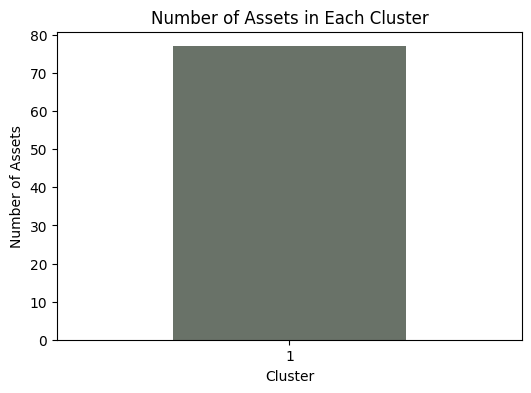

In [70]:
# Group assets by cluster and count the number of assets in each cluster
cluster_counts = representative_points['cluster_label'].value_counts().sort_index()

# Plot the number of assets in each cluster
plt.figure(figsize=(6, 4))
cluster_counts.plot(kind='bar', color=my_colors[1])
plt.xlabel('Cluster')
plt.ylabel('Number of Assets')
plt.title('Number of Assets in Each Cluster')
plt.xticks(rotation=0)
plt.show()

In [71]:
pca_df.to_csv('results/hierarchical/labels_most_common/single_link.csv', index= False)

In [77]:
pca_df = pca_df.loc[:,:'PC2']

df_scaled = df_scaled.loc[:,:4]

### Average Link

In [78]:
model_average = AgglomerativeClustering(linkage='average', distance_threshold=0.01, n_clusters=None)
model_average.fit(np.array(df_scaled))

AgglomerativeClustering(distance_threshold=0.01, linkage='average',
                        n_clusters=None)

In [79]:
average_labels = model_average.labels_

In [80]:
len(np.unique(average_labels))

38859

In [81]:
with open('results/hierarchical/average_clustering.pickle', 'wb') as f:
    pickle.dump(model_average, f)

In [19]:
with open('results/hierarchical/average_clustering.pickle', 'rb') as f:
    model_average = pickle.load(f)

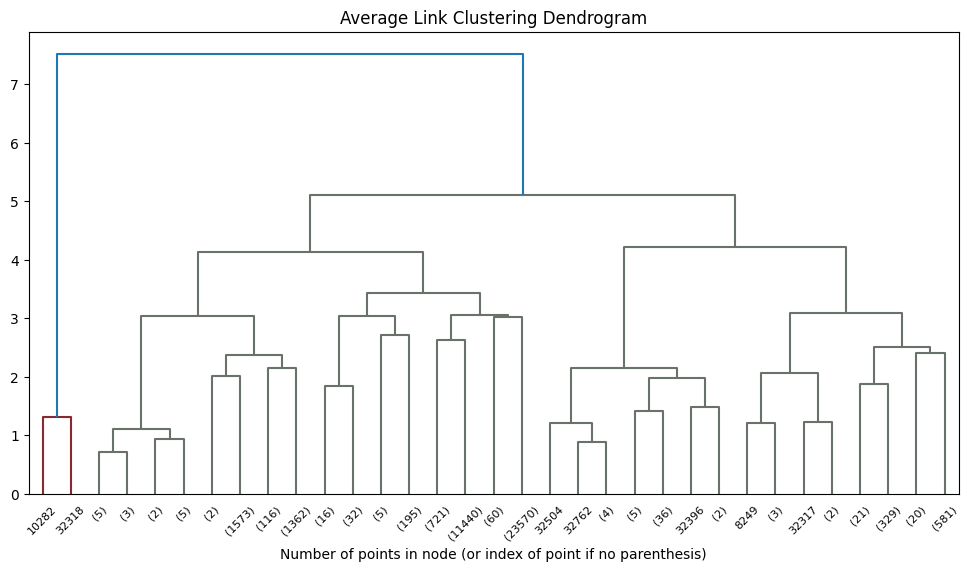

In [82]:
hierarchy.set_link_color_palette(my_colors)

plt.figure(figsize=(12, 6))
plt.title('Average Link Clustering Dendrogram')
# Plot the dendrogram
plot_dendrogram(model_average, truncate_mode='level', p = 5)
plt.xlabel("Number of points in node (or index of point if no parenthesis)")
plt.show()

In [89]:
# Cut dendrogram to obtain labels
num_clusters = 4  # Adjust as needed

# Convert the children_ attribute to a scipy hierarchical tree
linkage_matrix = np.column_stack([model_average.children_, model_average.distances_,
                                  np.ones_like(model_average.distances_)])
# Cut the tree to obtain labels
labels_cut = fcluster(linkage_matrix, num_clusters, criterion='maxclust')

print(labels_cut)

[2 2 2 ... 2 2 2]


In [90]:
len(np.unique(labels_cut))

4

In [91]:
# Assign the cluster labels to the original DataFrame
pca_df['cluster_label'] = labels_cut
pca_df['asset_id'] = df_subset['asset_id']

df_scaled['cluster_label'] = labels_cut
df_scaled['asset_id'] = df_subset['asset_id']

In [92]:
df_scaled.to_csv('results/hierarchical/csv_labels_cut_raw/average_link.csv', index=False)

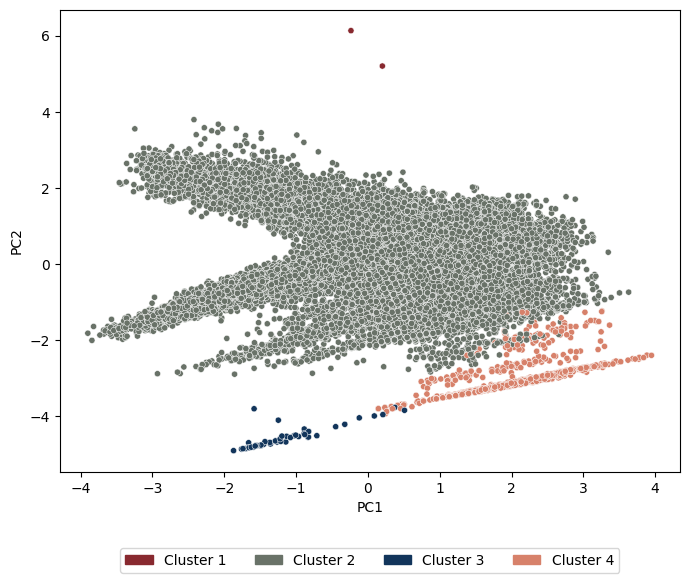

In [93]:
n_clusters = len(pca_df['cluster_label'].unique())
pallete = sns.color_palette(my_colors, n_clusters)

# Plot the representative points on a scatter plot using PCA results
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='cluster_label', palette=pallete, s=20)
# plt.title('Average Link')
plt.xlabel('PC1')
plt.ylabel('PC2')
legend_handles = [mpatches.Circle((0, 0), radius=1, color=color) for color in my_colors]
plt.legend(handles=legend_handles, labels=[f'Cluster {cluster_label}' for cluster_label in np.unique(labels_cut)],
           loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5)
plt.show()

In [95]:
most_frequent_clusters = pca_df.groupby('asset_id')['cluster_label'].agg(lambda x: np.bincount(x).argmax())

# Merge the most frequent cluster labels back to the original DataFrame
pca_df = pca_df.drop(columns='cluster_label')

pca_df = pd.merge(pca_df, most_frequent_clusters, on='asset_id', how='left')

pca_df.head()

,PC1,PC2,asset_id,cluster_label
0,1.073620,-2.073383,11,2
1,0.203757,-1.467581,11,2
2,1.005381,-1.059952,11,2
3,2.111048,-0.849120,11,2
4,-0.148070,-1.640123,11,2


In [96]:
len(pca_df['cluster_label'].unique())

1

In [97]:
representative_points = pca_df.groupby(['asset_id']).first().reset_index()
representative_points

,asset_id,PC1,PC2,cluster_label
0,11,1.073620,-2.073383,2
1,12,1.826629,-1.419172,2
2,13,-0.754270,0.041137,2
3,14,0.939960,0.034637,2
4,15,-0.538450,-0.000517,2
...,...,...,...,...
72,510,0.211749,0.019254,2
73,511,0.800390,0.061607,2
74,512,2.197902,-3.128753,2
75,513,-2.400037,2.145315,2


In [98]:
assets_clusters = representative_points.groupby('cluster_label')['asset_id']

# Print assets in each cluster
for cluster, assets in assets_clusters:
    print(f"Cluster {cluster}: {assets.index.tolist()}")

Cluster 2: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76]


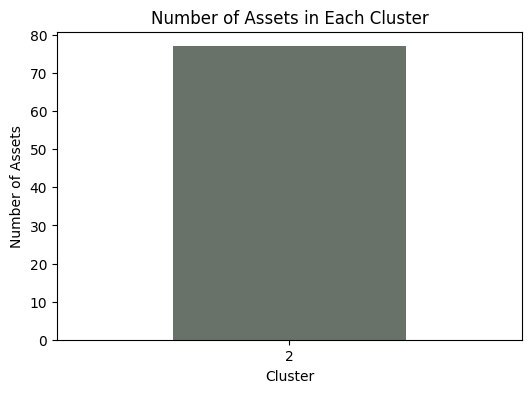

In [99]:
# Group assets by cluster and count the number of assets in each cluster
cluster_counts = representative_points['cluster_label'].value_counts().sort_index()

# Plot the number of assets in each cluster
plt.figure(figsize=(6, 4))
cluster_counts.plot(kind='bar', color=my_colors[1])
plt.xlabel('Cluster')
plt.ylabel('Number of Assets')
plt.title('Number of Assets in Each Cluster')
plt.xticks(rotation=0)
plt.show()

In [100]:
pca_df.to_csv('results/hierarchical/labels_most_common/average_link.csv', index=False)

In [108]:
pca_df = pca_df.loc[:,:'PC2']

df_scaled = df_scaled.loc[:,:4]

### Ward's method

In [109]:
model_ward = AgglomerativeClustering(linkage='ward', distance_threshold=0.01, n_clusters=None)
model_ward.fit(np.array(df_scaled))

AgglomerativeClustering(distance_threshold=0.01, n_clusters=None)

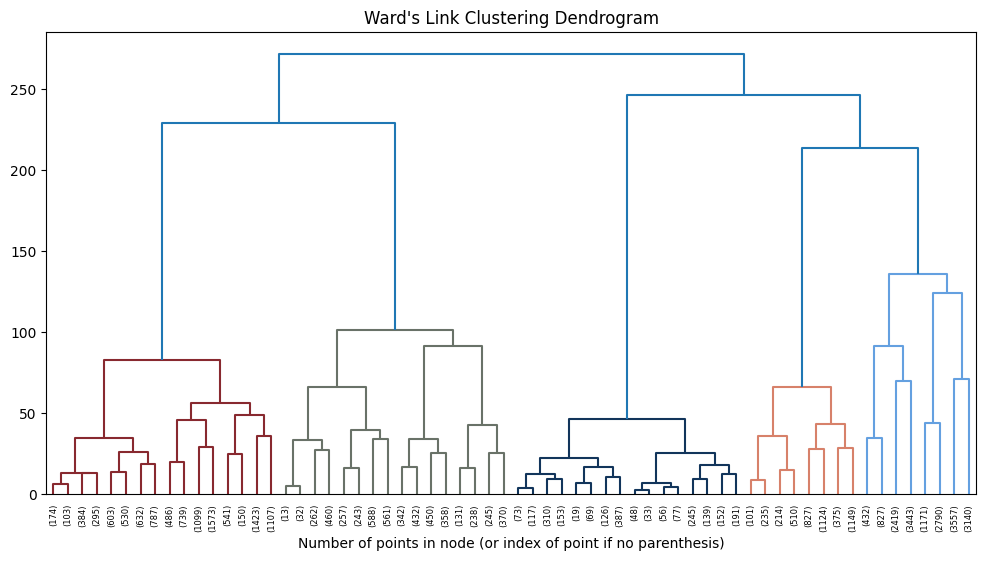

In [110]:
hierarchy.set_link_color_palette(my_colors)

plt.figure(figsize=(12, 6))
plt.title("Ward's Link Clustering Dendrogram")
# Plot the dendrogram
plot_dendrogram(model_ward, truncate_mode='level', p=5)
plt.xlabel("Number of points in node (or index of point if no parenthesis)")
plt.show()

In [111]:
with open('results/hierarchical/ward_clustering.pickle', 'wb') as f:
    pickle.dump(model_ward,f)

In [30]:
with open('results/hierarchical/ward_clustering.pickle', 'rb') as f:
    model_ward = pickle.load(f)

In [112]:
# Cut dendrogram to obtain labels
num_clusters = 5  # Adjust as needed

# Convert the children_ attribute to a scipy hierarchical tree
linkage_matrix = np.column_stack([model_ward.children_, model_ward.distances_,
                                  np.ones_like(model_ward.distances_)])
# Cut the tree to obtain labels
labels_cut = fcluster(linkage_matrix, num_clusters, criterion='maxclust')

print(labels_cut)

[2 2 2 ... 5 5 1]


In [113]:
pca_df = pca_df.loc[:,:'PC2']

In [114]:
# Assign the cluster labels to the original DataFrame
pca_df['cluster_label'] = labels_cut
pca_df['asset_id'] = df_subset['asset_id']

df_scaled['cluster_label'] = labels_cut
df_scaled['asset_id'] = df_subset['asset_id']

In [115]:
df_scaled.to_csv('results/hierarchical/csv_labels_cut_raw/ward_link.csv', index=False)

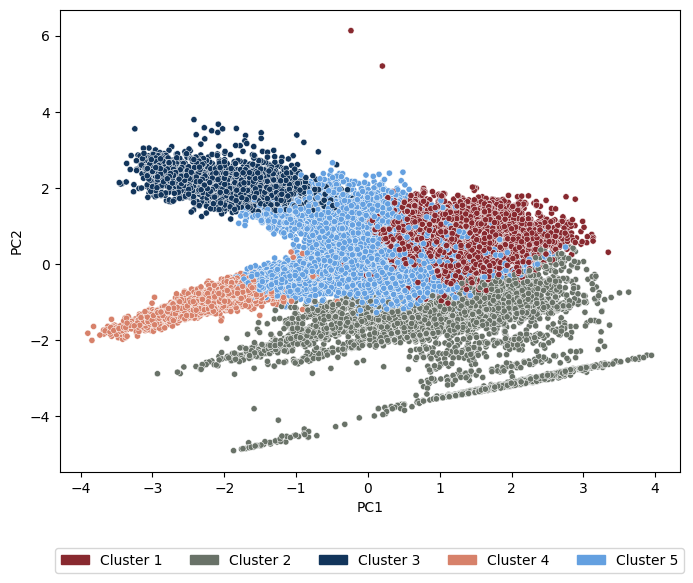

In [116]:
n_clusters = len(pca_df['cluster_label'].unique())
pallete = sns.color_palette(my_colors, n_clusters)

# Plot the representative points on a scatter plot using PCA results
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='cluster_label', palette=pallete, s=20)
# plt.title("Ward's Link")
plt.xlabel('PC1')
plt.ylabel('PC2')
legend_handles = [mpatches.Circle((0, 0), radius=1, color=color) for color in my_colors]
plt.legend(handles=legend_handles, labels=[f'Cluster {cluster_label}' for cluster_label in np.unique(labels_cut)],
            loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5)
plt.show()

In [117]:
most_frequent_clusters = pca_df.groupby('asset_id')['cluster_label'].agg(lambda x: np.bincount(x).argmax())

# Merge the most frequent cluster labels back to the original DataFrame
pca_df = pca_df.drop(columns='cluster_label')

pca_df = pd.merge(pca_df, most_frequent_clusters, on='asset_id', how='left')

pca_df.head()

,PC1,PC2,asset_id,cluster_label
0,1.073620,-2.073383,11,2
1,0.203757,-1.467581,11,2
2,1.005381,-1.059952,11,2
3,2.111048,-0.849120,11,2
4,-0.148070,-1.640123,11,2


In [118]:
len(most_frequent_clusters.unique())

4

In [119]:
representative_points = pca_df.groupby(['asset_id']).first().reset_index()
representative_points

,asset_id,PC1,PC2,cluster_label
0,11,1.073620,-2.073383,2
1,12,1.826629,-1.419172,2
2,13,-0.754270,0.041137,5
3,14,0.939960,0.034637,5
4,15,-0.538450,-0.000517,5
...,...,...,...,...
72,510,0.211749,0.019254,5
73,511,0.800390,0.061607,5
74,512,2.197902,-3.128753,3
75,513,-2.400037,2.145315,3


In [120]:
pca_df.to_csv('results/hierarchical/labels_most_common/ward_link.csv', index=False)

In [121]:
pca_df = pca_df.loc[:, 'PC1':'PC2']

In [122]:
assets_clusters = representative_points.groupby('cluster_label')['asset_id']

# Print assets in each cluster
for cluster, assets in assets_clusters:
    print(f"Cluster {cluster}: {assets.index.tolist()}")

Cluster 1: [37, 40]
Cluster 2: [0, 1, 23, 33, 52, 58]
Cluster 3: [74, 75]
Cluster 5: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 35, 36, 38, 39, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 53, 54, 55, 56, 57, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 76]


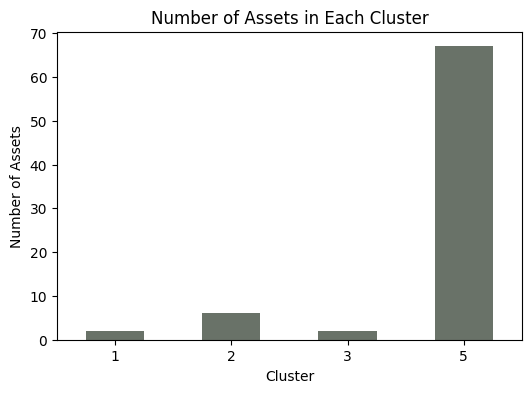

In [123]:
# Group assets by cluster and count the number of assets in each cluster
cluster_counts = representative_points['cluster_label'].value_counts().sort_index()

# Plot the number of assets in each cluster
plt.figure(figsize=(6, 4))
cluster_counts.plot(kind='bar', color=my_colors[1])
plt.xlabel('Cluster')
plt.ylabel('Number of Assets')
plt.title('Number of Assets in Each Cluster')
plt.xticks(rotation=0)
plt.show()

In [125]:
df_scaled = df_scaled.loc[:,:4]

### Centroid Linkage

In [126]:
# Perform hierarchical clustering
model_centroid = linkage(df_scaled, 'centroid')

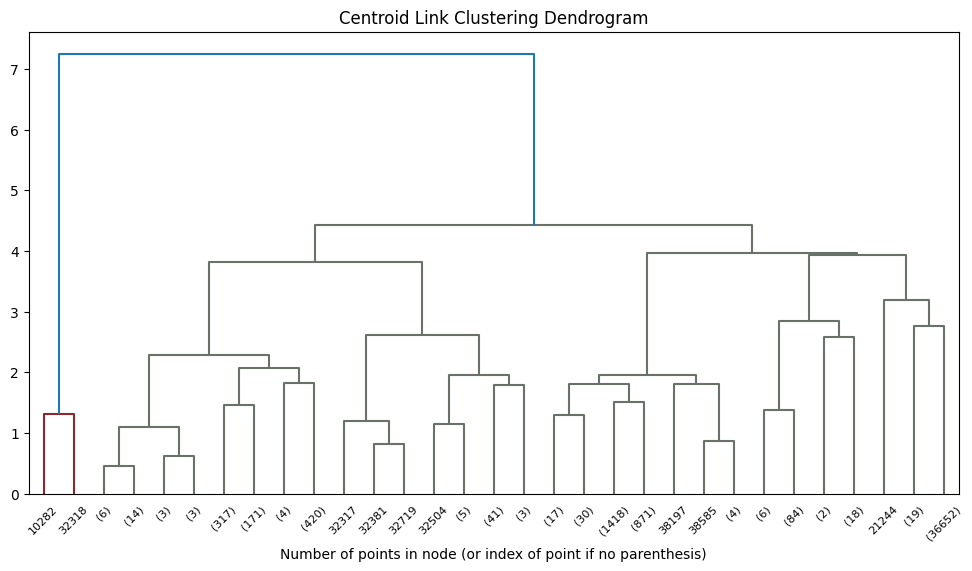

In [127]:
hierarchy.set_link_color_palette(my_colors)

plt.figure(figsize=(12, 6))
plt.title('Centroid Link Clustering Dendrogram')
# Plot the dendrogram
dendrogram(model_centroid, truncate_mode='level', p = 5, leaf_rotation=45)
plt.xlabel("Number of points in node (or index of point if no parenthesis)")
plt.show()

In [128]:
with open('results/hierarchical/centroid_clustering.pickle', 'wb') as f:
    pickle.dump(model_centroid,f)

In [32]:
with open('results/hierarchical/centroid_clustering.pickle', 'rb') as f:
    model_centroid = pickle.load(f)

In [129]:
# Cut dendrogram to obtain labels
num_clusters = 2  # Adjust as needed

# Cut the tree to obtain labels
labels_cut = fcluster(model_centroid, num_clusters, criterion='maxclust')

print(labels_cut)

[2 2 2 ... 2 2 2]


In [130]:
pca_df = pca_df.loc[:,:'PC2']

In [131]:
# Assign the cluster labels to the original DataFrame
pca_df['cluster_label'] = labels_cut
pca_df['asset_id'] = df_subset['asset_id']

df_scaled['cluster_label'] = labels_cut
df_scaled['asset_id'] = df_subset['asset_id']

In [132]:
df_scaled.to_csv('results/hierarchical/csv_labels_cut_raw/centroid_link.csv', index=False)

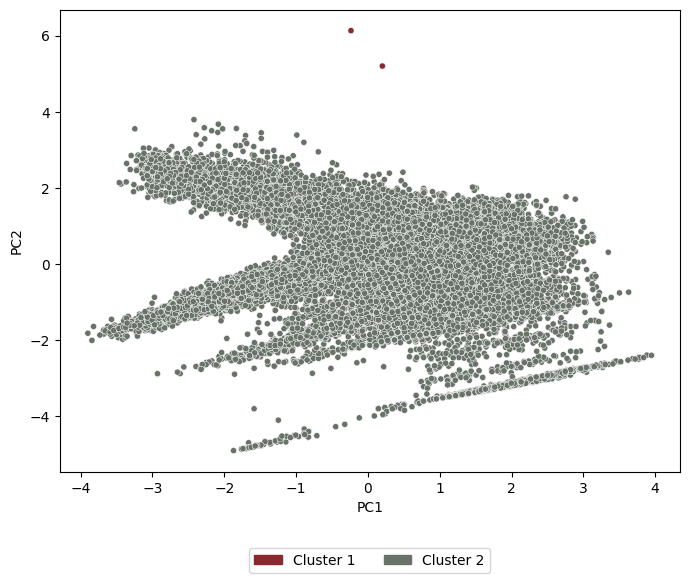

In [133]:
n_clusters = len(pca_df['cluster_label'].unique())
pallete = sns.color_palette(my_colors, n_clusters)

# Plot the representative points on a scatter plot using PCA results
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='cluster_label', palette=pallete, s=20)
# plt.title("Centroid Link")
plt.xlabel('PC1')
plt.ylabel('PC2')
legend_handles = [mpatches.Circle((0, 0), radius=1, color=color) for color in my_colors]
plt.legend(handles=legend_handles, labels=[f'Cluster {cluster_label}' for cluster_label in np.unique(labels_cut)],
           loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5)
plt.show()

In [134]:
most_frequent_clusters = pca_df.groupby('asset_id')['cluster_label'].agg(lambda x: np.bincount(x).argmax())

# Merge the most frequent cluster labels back to the original DataFrame
pca_df = pca_df.drop(columns='cluster_label')

pca_df = pd.merge(pca_df, most_frequent_clusters, on='asset_id', how='left')

pca_df.head()

,PC1,PC2,asset_id,cluster_label
0,1.073620,-2.073383,11,2
1,0.203757,-1.467581,11,2
2,1.005381,-1.059952,11,2
3,2.111048,-0.849120,11,2
4,-0.148070,-1.640123,11,2


In [135]:
len(most_frequent_clusters.unique())

1

In [136]:
representative_points = pca_df.groupby(['asset_id']).first().reset_index()
representative_points

,asset_id,PC1,PC2,cluster_label
0,11,1.073620,-2.073383,2
1,12,1.826629,-1.419172,2
2,13,-0.754270,0.041137,2
3,14,0.939960,0.034637,2
4,15,-0.538450,-0.000517,2
...,...,...,...,...
72,510,0.211749,0.019254,2
73,511,0.800390,0.061607,2
74,512,2.197902,-3.128753,2
75,513,-2.400037,2.145315,2


In [137]:
pca_df.to_csv('results/hierarchical/labels_most_common/centroid_link.csv', index=False)

In [138]:
assets_clusters = representative_points.groupby('cluster_label')['asset_id']

# Print assets in each cluster
for cluster, assets in assets_clusters:
    print(f"Cluster {cluster}: {assets.index.tolist()}")

Cluster 2: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76]


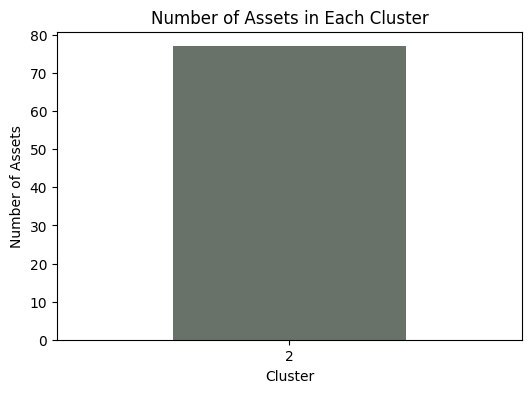

In [139]:
# Group assets by cluster and count the number of assets in each cluster
cluster_counts = representative_points['cluster_label'].value_counts().sort_index()

# Plot the number of assets in each cluster
plt.figure(figsize=(6, 4))
cluster_counts.plot(kind='bar', color=my_colors[1])
plt.xlabel('Cluster')
plt.ylabel('Number of Assets')
plt.title('Number of Assets in Each Cluster')
plt.xticks(rotation=0)
plt.show()

### BIRCH

In [140]:
pca_df = pca_df.loc[:,:'PC2']

df_scaled = df_scaled.loc[:,:4]

In [143]:
brc = Birch(n_clusters=None, threshold=1.5)
brc.fit(df_scaled)

Birch(n_clusters=None, threshold=1.5)

In [142]:
with open('results/hierarchical/birch_clustering.pickle', 'wb') as f:
   pickle.dump(brc, f)

In [144]:
labels = brc.predict(df_scaled)
labels

array([16, 16, 16, ..., 10, 10,  5])

In [145]:
pca_df['cluster_label'] = labels
pca_df['asset_id'] = df_subset['asset_id']

df_scaled['cluster_label'] = labels
df_scaled['asset_id'] = df_subset['asset_id']
df_scaled.head()

,0,1,2,3,4,cluster_label,asset_id
0,-0.508250,-0.893884,-2.667186,0.163522,-0.072287,16,11
1,-0.469440,-0.605656,-1.540451,0.408095,-0.780179,16,11
2,-0.462222,-0.566264,-1.417633,-0.185869,0.300288,16,11
3,-0.499687,-0.826978,-1.690806,-0.360564,1.902361,0,11
4,-0.211838,1.313884,-1.545407,-1.059346,-0.705664,2,11


In [146]:
df_scaled.to_csv('results/hierarchical/csv_labels_cut_raw/birch.csv', index = False)

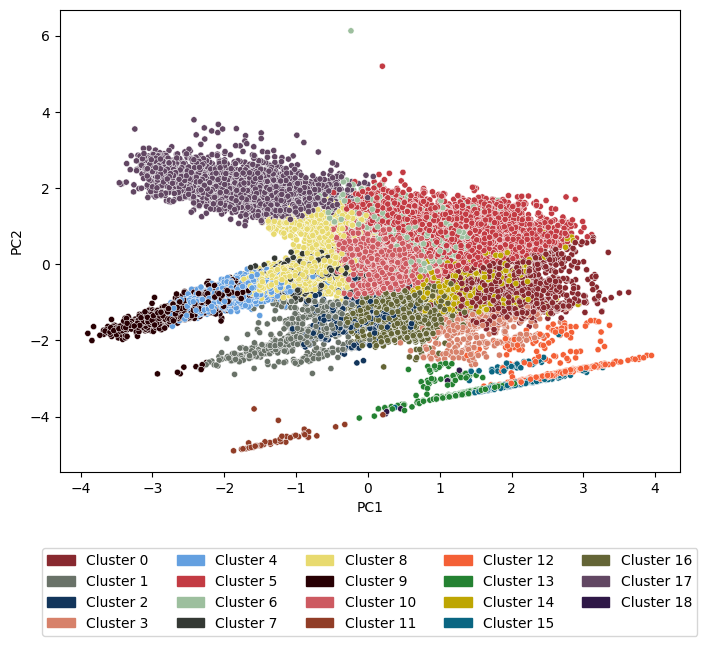

In [147]:
n_clusters = len(pca_df['cluster_label'].unique())
pallete = sns.color_palette(my_colors, n_clusters)

# Plot the representative points on a scatter plot using PCA results
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='cluster_label', palette=pallete, s=20)
# plt.title("BIRCH")
plt.xlabel('PC1')
plt.ylabel('PC2')
legend_handles = [mpatches.Circle((0, 0), radius=1, color=color) for color in my_colors]
plt.legend(handles=legend_handles, labels=[f'Cluster {cluster_label}' for cluster_label in np.unique(labels)],
           loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5)
plt.show()

In [148]:
most_frequent_clusters = pca_df.groupby('asset_id')['cluster_label'].agg(lambda x: np.bincount(x).argmax())

# Merge the most frequent cluster labels back to the original DataFrame
pca_df = pca_df.drop(columns='cluster_label')

pca_df = pd.merge(pca_df, most_frequent_clusters, on='asset_id', how='left')

pca_df.head()

,PC1,PC2,asset_id,cluster_label
0,1.073620,-2.073383,11,0
1,0.203757,-1.467581,11,0
2,1.005381,-1.059952,11,0
3,2.111048,-0.849120,11,0
4,-0.148070,-1.640123,11,0


In [149]:
len(most_frequent_clusters.unique())

6

In [150]:
representative_points = pca_df.groupby(['asset_id']).first().reset_index()
representative_points

,asset_id,PC1,PC2,cluster_label
0,11,1.073620,-2.073383,0
1,12,1.826629,-1.419172,16
2,13,-0.754270,0.041137,5
3,14,0.939960,0.034637,5
4,15,-0.538450,-0.000517,5
...,...,...,...,...
72,510,0.211749,0.019254,17
73,511,0.800390,0.061607,17
74,512,2.197902,-3.128753,17
75,513,-2.400037,2.145315,17


In [151]:
assets_clusters = pca_df.groupby('asset_id')['cluster_label'].agg(lambda x: np.bincount(x).argmax())

# Print assets in each cluster
for cluster, assets in assets_clusters.groupby(assets_clusters):
    print(f"Cluster {cluster}: {assets.index.tolist()}")

Cluster 0: [11, 214, 312]
Cluster 5: [13, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 32, 33, 34, 35, 36, 37, 38, 44, 52, 55, 110, 111, 112, 210, 211, 212, 213, 215, 216, 217, 310, 313, 314, 315, 317, 412, 415]
Cluster 8: [41, 42, 43, 49, 410, 411, 413, 414, 417]
Cluster 10: [39, 45, 46, 48, 311, 316, 416]
Cluster 16: [12, 47]
Cluster 17: [51, 53, 54, 56, 57, 58, 59, 510, 511, 512, 513, 514]


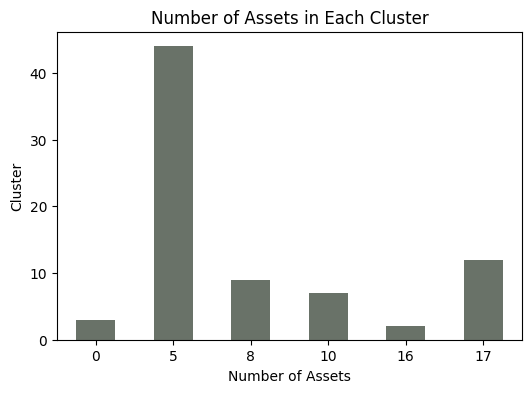

In [152]:
# Group assets by cluster and count the number of assets in each cluster
cluster_counts = assets_clusters.value_counts().sort_index()

# Plot the number of assets in each cluster
plt.figure(figsize=(6, 4))
cluster_counts.plot(kind='bar', color=my_colors[1])
plt.xlabel('Number of Assets')
plt.ylabel('Cluster')
plt.title('Number of Assets in Each Cluster')
plt.xticks(rotation=0)
plt.show()

In [153]:
pca_df.to_csv('results/hierarchical/labels_most_common/birch.csv', index = False)